In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms

In [29]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

batch_size = 5

In [30]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [31]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [32]:
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [33]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [34]:
import matplotlib.pyplot as plt
import numpy as np

In [35]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


In [36]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

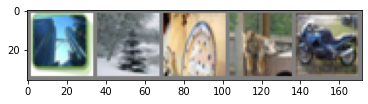

In [37]:
imshow(torchvision.utils.make_grid(images))

In [38]:
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [39]:
labels

tensor([76, 59, 61, 42, 48])

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [41]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
)

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [43]:
# net.to(device)
# criterion.to(device)

In [44]:
for epoch in range(10):  # loop over the dataset multiple times
    net.train()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 4.357
[1,  4000] loss: 3.968
[1,  6000] loss: 3.779
[1,  8000] loss: 3.636
[1, 10000] loss: 3.548
[2,  2000] loss: 3.388
[2,  4000] loss: 3.393
[2,  6000] loss: 3.321
[2,  8000] loss: 3.319
[2, 10000] loss: 3.259
[3,  2000] loss: 3.146
[3,  4000] loss: 3.145
[3,  6000] loss: 3.156
[3,  8000] loss: 3.120
[3, 10000] loss: 3.154
[4,  2000] loss: 3.001
[4,  4000] loss: 3.038
[4,  6000] loss: 3.000
[4,  8000] loss: 3.046
[4, 10000] loss: 3.031
[5,  2000] loss: 2.871
[5,  4000] loss: 2.901
[5,  6000] loss: 2.976
[5,  8000] loss: 2.977
[5, 10000] loss: 2.969
[6,  2000] loss: 2.770
[6,  4000] loss: 2.862
[6,  6000] loss: 2.883
[6,  8000] loss: 2.885
[6, 10000] loss: 2.928
[7,  2000] loss: 2.739
[7,  4000] loss: 2.791
[7,  6000] loss: 2.847
[7,  8000] loss: 2.850
[7, 10000] loss: 2.859
[8,  2000] loss: 2.661
[8,  4000] loss: 2.736
[8,  6000] loss: 2.805
[8,  8000] loss: 2.817
[8, 10000] loss: 2.830
[9,  2000] loss: 2.648
[9,  4000] loss: 2.655
[9,  6000] loss: 2.743
[9,  8000] 

In [45]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 23 %
